KAleep-Net: A Kolmogorov-Arnold Flash Attention Network for Sleep
Stage Classification Using Single-Channel EEG With Explainability

1. Install required libraries

In [ ]:
pip install mne numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 49.8 MB/s eta 0:00:00


2. Read a single EEG EDF file and extract signal

In [ ]:
pip install streamlit numpy scipy scikit-learn torch mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.8 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok

In [ ]:
from pyngrok import ngrok
import os

ngrok.set_auth_token("2vzxKMKMKwaF4LKPbc0gskG9ETr_4VKaCei5e1dvAmpdxBSep")
os.system("streamlit run app.py &")
public_url = ngrok.connect(8501)
print(public_url)


NgrokTunnel: "https://6e72ff911ca9.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!pip install mne scipy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 39.5 MB/s eta 0:00:00


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving SC4001E0-PSG.edf to SC4001E0-PSG.edf


In [ ]:
import numpy as np
import mne
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
import os

def bandpass_filter(signal, fs, low=0.3, high=35):
    b, a = butter(4, [low/(fs/2), high/(fs/2)], btype="band")
    return filtfilt(b, a, signal)

def epoch_signal(signal, fs, epoch_sec=30):
    samples = int(epoch_sec * fs)
    epochs = []
    for i in range(0, len(signal) - samples, samples):
        epochs.append(signal[i:i+samples])
    return np.array(epochs)

def normalize(epochs):
    mean = epochs.mean(axis=1, keepdims=True)
    std = epochs.std(axis=1, keepdims=True) + 1e-8
    return (epochs - mean) / std

def extract_features(epoch, fs):
    f, psd = welch(epoch, fs)
    return [
        np.mean(epoch),
        np.std(epoch),
        np.var(epoch),
        skew(epoch),
        kurtosis(epoch),
        np.sum(psd[(f>=0.5)&(f<4)]),
        np.sum(psd[(f>=4)&(f<8)]),
        np.sum(psd[(f>=8)&(f<13)]),
        np.sum(psd[(f>=13)&(f<30)])
    ]

def extract_feature_matrix(epochs, fs):
    return np.array([extract_features(e, fs) for e in epochs])

def load_eeg(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.pick_channels([raw.ch_names[0]])
    signal = raw.get_data()[0]
    fs = raw.info["sfreq"]
    return signal, fs

for file_name in os.listdir():
    if not file_name.endswith(".edf"):
        continue

    print(f"\nProcessing file: {file_name}")

    signal, fs = load_eeg(file_name)
    signal = bandpass_filter(signal, fs)
    epochs = epoch_signal(signal, fs)
    epochs = normalize(epochs)
    features = extract_feature_matrix(epochs, fs)

    print("Sampling Rate:", fs)
    print("Total Epochs:", epochs.shape[0])
    print("Feature Shape:", features.shape)
    print("Sample Feature Vector:", features[0])



Processing file: SC4001E0-PSG.edf


/tmp/ipython-input-867338025.py:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-867338025.py:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-867338025.py:41: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling Rate: 100.0
Total Epochs: 2649
Feature Shape: (2649, 9)
Sample Feature Vector: [-7.10542736e-18  9.99702038e-01  9.99404165e-01  9.56851693e-02
  1.75733582e+00  1.32078745e+00  2.00166421e-01  2.05169202e-02
  2.33389524e-02]


In [ ]:
!pip install mne scipy scikit-learn torch matplotlib


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving SC4002E0-PSG.edf to SC4002E0-PSG.edf
Saving SC4181EC-Hypnogram.edf to SC4181EC-Hypnogram.edf


/tmp/ipython-input-2596071143.py:49: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_name, preload=True, verbose=False)
/tmp/ipython-input-2596071143.py:49: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_name, preload=True, verbose=False)
/tmp/ipython-input-2596071143.py:49: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_name, preload=True, verbose=False)


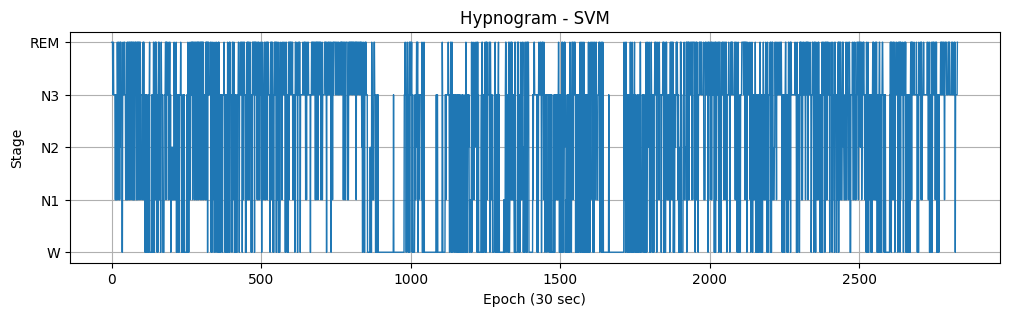

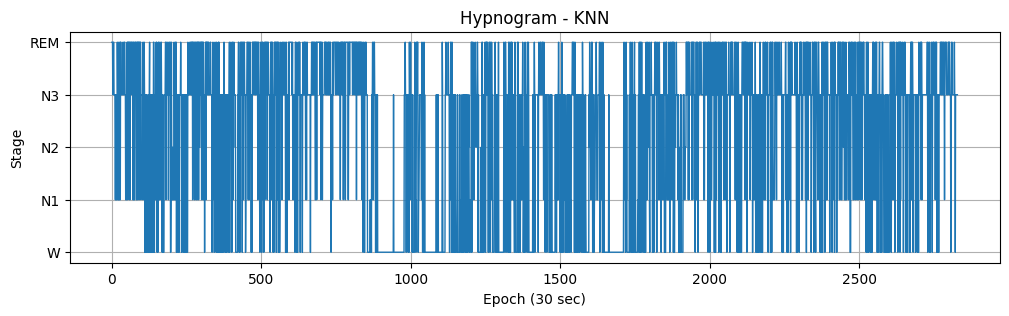

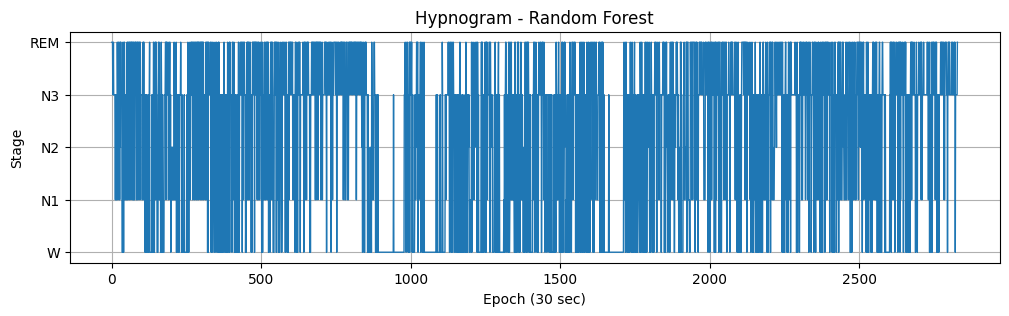

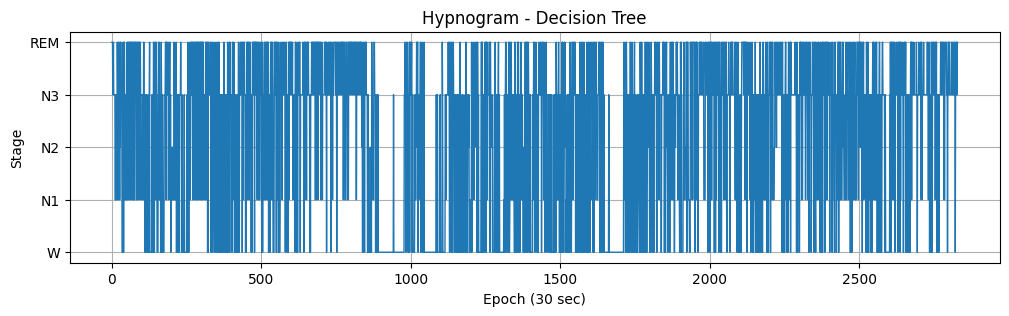

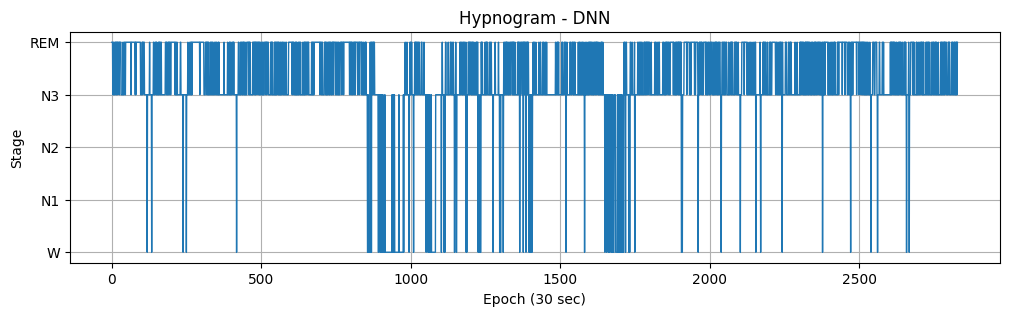

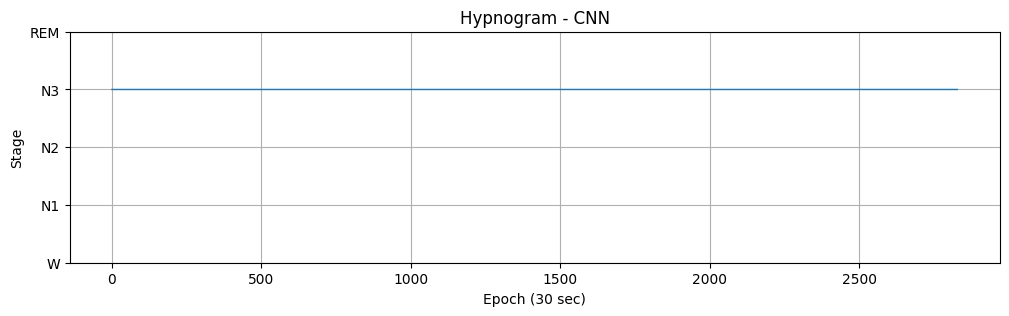

In [ ]:
import numpy as np
import mne
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ===================== EEG PREPROCESSING =====================
def bandpass_filter(signal, fs, low=0.3, high=35):
    b, a = butter(4, [low/(fs/2), high/(fs/2)], btype="band")
    return filtfilt(b, a, signal)

def epoch_signal(signal, fs, epoch_sec=30):
    samples = int(epoch_sec * fs)
    return np.array([signal[i:i+samples] for i in range(0, len(signal)-samples, samples)])

def normalize(epochs):
    return (epochs - epochs.mean(axis=1, keepdims=True)) / (epochs.std(axis=1, keepdims=True) + 1e-8)

# ===================== FEATURE EXTRACTION =====================
def extract_features(epoch, fs):
    f, psd = welch(epoch, fs)
    return [
        np.mean(epoch),
        np.std(epoch),
        skew(epoch),
        kurtosis(epoch),
        np.sum(psd[(f>=0.5)&(f<4)]),
        np.sum(psd[(f>=4)&(f<8)]),
        np.sum(psd[(f>=8)&(f<13)]),
        np.sum(psd[(f>=13)&(f<30)])
    ]

def extract_feature_matrix(epochs, fs):
    return np.array([extract_features(e, fs) for e in epochs])

# ===================== LOAD EDF =====================
file_name = [f for f in uploaded.keys()][0]
raw = mne.io.read_raw_edf(file_name, preload=True, verbose=False)
raw.pick(raw.ch_names[0])
signal = raw.get_data()[0]
fs = raw.info["sfreq"]

signal = bandpass_filter(signal, fs)
epochs = normalize(epoch_signal(signal, fs))
X_features = extract_feature_matrix(epochs, fs)

# ===================== PSEUDO LABELS =====================
kmeans = KMeans(n_clusters=5, random_state=42)
y_pseudo = kmeans.fit_predict(X_features)

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_pseudo, test_size=0.2, random_state=42
)

# ===================== ML MODELS =====================
models = {
    "SVM": Pipeline([("scaler", StandardScaler()), ("clf", SVC())]),
    "KNN": Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(5))]),
    "Random Forest": RandomForestClassifier(100),
    "Decision Tree": DecisionTreeClassifier()
}

predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_features)

# ===================== DNN =====================
class DNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 5)
        )
    def forward(self, x):
        return self.net(x)

X_torch = torch.tensor(X_train, dtype=torch.float32)
y_torch = torch.tensor(y_train, dtype=torch.long)

dnn = DNN(X_features.shape[1])
opt = torch.optim.Adam(dnn.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

for _ in range(30):
    opt.zero_grad()
    loss = loss_fn(dnn(X_torch), y_torch)
    loss.backward()
    opt.step()

predictions["DNN"] = torch.argmax(
    dnn(torch.tensor(X_features, dtype=torch.float32)), dim=1
).numpy()

# ===================== CNN =====================
class CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, 7),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(32, 5)
        )
    def forward(self, x):
        return self.net(x)

epochs_cnn = torch.tensor(epochs[:, None, :], dtype=torch.float32)
y_cnn = torch.tensor(y_pseudo, dtype=torch.long)

cnn = CNN1D()
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)

for _ in range(20):
    opt.zero_grad()
    loss = loss_fn(cnn(epochs_cnn), y_cnn)
    loss.backward()
    opt.step()

predictions["CNN"] = torch.argmax(cnn(epochs_cnn), dim=1).numpy()

# ===================== HYPNOGRAM PLOT =====================
stage_map = ["W", "N1", "N2", "N3", "REM"]

def plot_hypnogram(pred, title):
    plt.figure(figsize=(12,3))
    plt.plot(pred, linewidth=1)
    plt.yticks(range(5), stage_map)
    plt.xlabel("Epoch (30 sec)")
    plt.ylabel("Stage")
    plt.title(title)
    plt.grid(True)
    plt.show()

for name, pred in predictions.items():
    plot_hypnogram(pred, f"Hypnogram - {name}")


In [ ]:
from sklearn.metrics import accuracy_score
import time

accuracy_scores = {}
execution_times = {}

# ML models
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    execution_times[name] = time.time() - start
    accuracy_scores[name] = accuracy_score(y_test, y_pred)

# DNN accuracy
y_test_torch = torch.tensor(y_test, dtype=torch.long)
with torch.no_grad():
    y_pred_dnn = torch.argmax(
        dnn(torch.tensor(X_test, dtype=torch.float32)), dim=1
    ).numpy()
accuracy_scores["DNN"] = accuracy_score(y_test, y_pred_dnn)
execution_times["DNN"] = 0

# CNN accuracy
with torch.no_grad():
    y_pred_cnn = torch.argmax(cnn(epochs_cnn[:len(y_test)]), dim=1).numpy()
accuracy_scores["CNN"] = accuracy_score(y_test, y_pred_cnn)
execution_times["CNN"] = 0


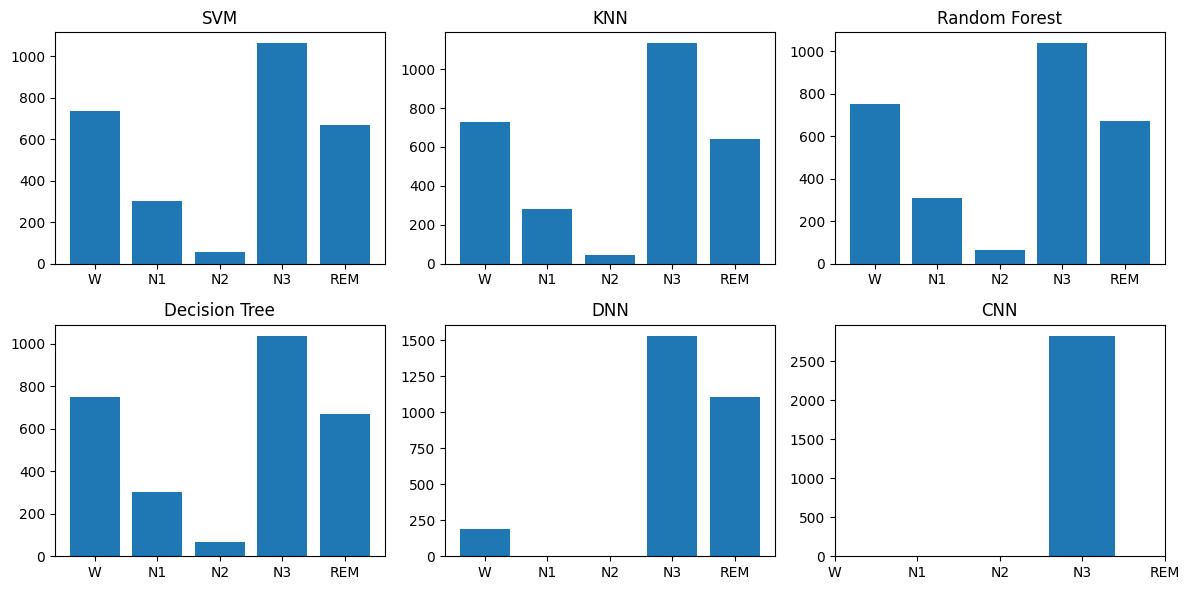

In [ ]:
plt.figure(figsize=(12,6))

for i, (name, pred) in enumerate(predictions.items()):
    plt.subplot(2, 3, i+1)
    unique, counts = np.unique(pred, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(range(5), ["W","N1","N2","N3","REM"])
    plt.title(name)
    plt.tight_layout()

plt.show()


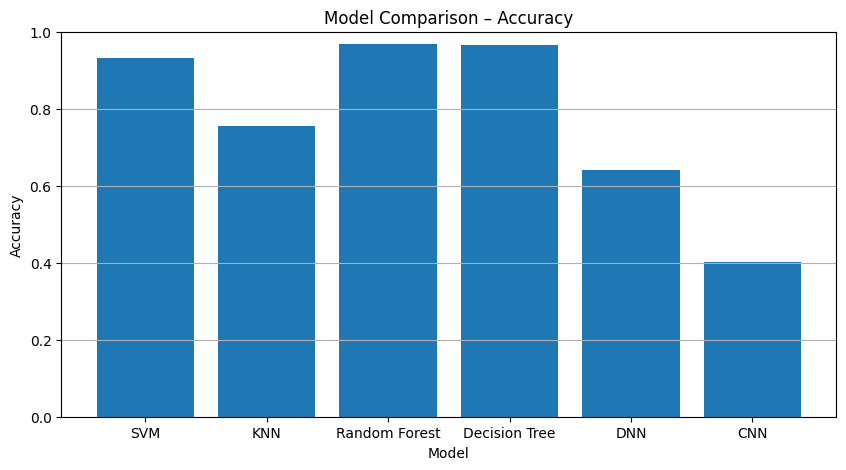

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values())
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Model Comparison – Accuracy")
plt.ylim(0,1)
plt.grid(axis="y")
plt.show()


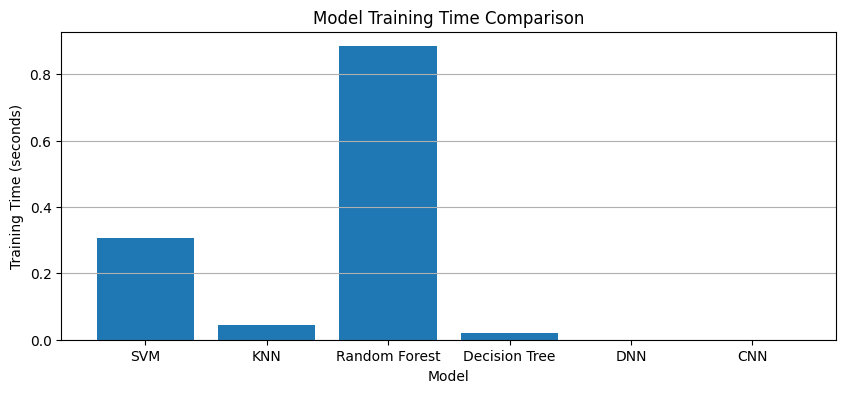

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(execution_times.keys(), execution_times.values())
plt.ylabel("Training Time (seconds)")
plt.xlabel("Model")
plt.title("Model Training Time Comparison")
plt.grid(axis="y")
plt.show()
